# Visualising with Pyshp

to visualize the information extracted from data, the libraries in below are also needed. For example, the Python Shapefile Library (pyshp) provides read and write support for the ESRI Shapefile format. And Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import geopandas as gpd
import shapefile
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# this section of the code from https://chih-ling-hsu.github.io/2018/05/14/NYC#1-define-short-and-long-distance
## author: Chih-Ling Hsu
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [3]:
# this section of the code from https://chih-ling-hsu.github.io/2018/05/14/NYC#1-define-short-and-long-distance
## author: Chih-Ling Hsu
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [4]:
# this section of the code from https://chih-ling-hsu.github.io/2018/05/14/NYC#1-define-short-and-long-distance
## author: Chih-Ling Hsu
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [5]:
# this section of the code from https://chih-ling-hsu.github.io/2018/05/14/NYC#1-define-short-and-long-distance
## author: Chih-Ling Hsu
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [6]:
# this section of the code from https://chih-ling-hsu.github.io/2018/05/14/NYC#1-define-short-and-long-distance
## author: Chih-Ling Hsu
sf = shapefile.Reader("../data/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


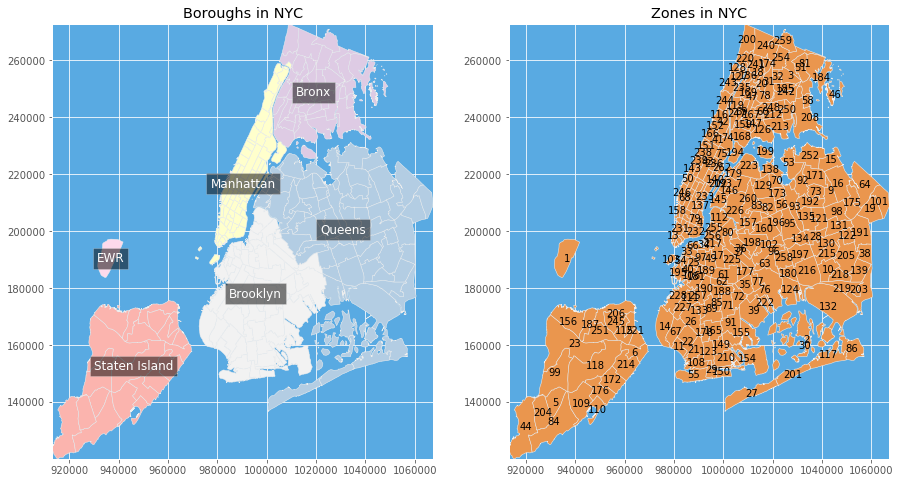

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)
plt.savefig('../plots/Location_data')

## Visualize the top 5 regions with the most pickups and drop-offs in 2019

In [20]:
# import pick up dfs of 2019 and 2020
pickup_df_19 = pd.read_csv("../processed_data/Pickuplocation_trip_count_2019.csv").iloc[: , 1:]

pickup_df_19.sort_values(by = ['PULocationID'],inplace = True)
pickup_df_19.rename({'PULocationID': 'LocationID', 'count': 'PUcount'}, axis=1, inplace=True)

pickup_df_19

,LocationID,PUcount
57,1,8644
235,2,106
71,3,2106
125,4,142810
86,5,345
...,...,...
162,261,491970
99,262,1017407
110,263,1545850
154,264,786872


In [21]:
# import drop off dfs of 2019 and 2020
dropoff_df_19 = pd.read_csv("../processed_data/Dropofflocation_trip_count_2019.csv").iloc[: , 1:]

dropoff_df_19.sort_values(by = ['DOLocationID'], inplace = True)
dropoff_df_19.rename({'DOLocationID': 'LocationID', 'count': 'DOcount'}, axis=1, inplace=True)

dropoff_df_19

,LocationID,DOcount
57,1,175514
236,2,95
71,3,7278
125,4,361982
87,5,798
...,...,...
163,261,394882
99,262,1094669
111,263,1575520
154,264,768288


In [22]:
df_pu = pickup_df_19
df_do = dropoff_df_19

In [23]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PU_19 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID")
PUtop3 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(3)
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))
DO_19 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID")
DOtop3 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(3)

In [24]:
PUtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
237,3641682.0,3256021.0,6897703.0,Upper East Side South,Manhattan
161,3450649.0,3261232.0,6711881.0,Midtown Center,Manhattan
236,3291351.0,3429838.0,6721189.0,Upper East Side North,Manhattan


In [25]:
DOtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
236,3291351.0,3429838.0,6721189.0,Upper East Side North,Manhattan
161,3450649.0,3261232.0,6711881.0,Midtown Center,Manhattan
237,3641682.0,3256021.0,6897703.0,Upper East Side South,Manhattan


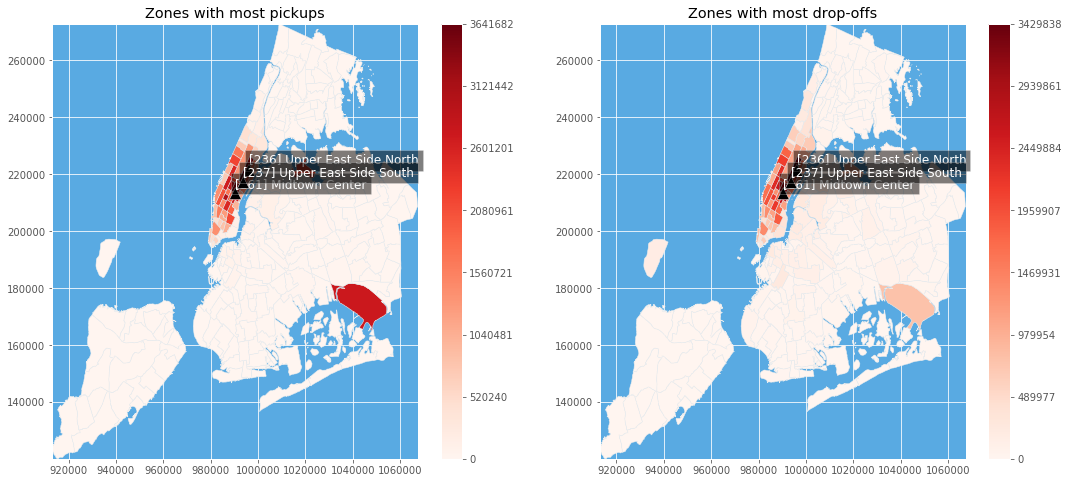

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())
#plt.savefig('../plots/pickupdropoff_2019')

## Visualize the top 5 regions with the most pickups and drop-offs in 2020

In [27]:
# import pick up dfs of 2019 and 2020
pickup_df_20 = pd.read_csv("../processed_data/Pickuplocation_trip_count_2020.csv").iloc[: , 1:]

pickup_df_20.sort_values(by = ['PULocationID'],inplace = True)
pickup_df_20.rename({'PULocationID': 'LocationID', 'count': 'PUcount'}, axis=1, inplace=True)

pickup_df_20

,LocationID,PUcount
57,1,2114
235,2,25
71,3,1865
126,4,35561
87,5,109
...,...,...
162,261,110679
99,262,361982
110,263,573810
154,264,166693


In [28]:
# import drop off dfs of 2019 and 2020
dropoff_df_20 = pd.read_csv("../processed_data/Dropofflocation_trip_count_2020.csv").iloc[: , 1:]

dropoff_df_20.sort_values(by = ['DOLocationID'], inplace = True)
dropoff_df_20.rename({'DOLocationID': 'LocationID', 'count': 'DOcount'}, axis=1, inplace=True)

dropoff_df_20

,LocationID,DOcount
57,1,34573
235,2,45
70,3,3808
125,4,109250
87,5,312
...,...,...
163,261,93041
99,262,380021
110,263,541630
154,264,152443


In [29]:
df_pu = pickup_df_20
df_do = dropoff_df_20

In [30]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PUtop3 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(3)
PU_20 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID")
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))
DOtop3 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(3)
DO_20 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID")

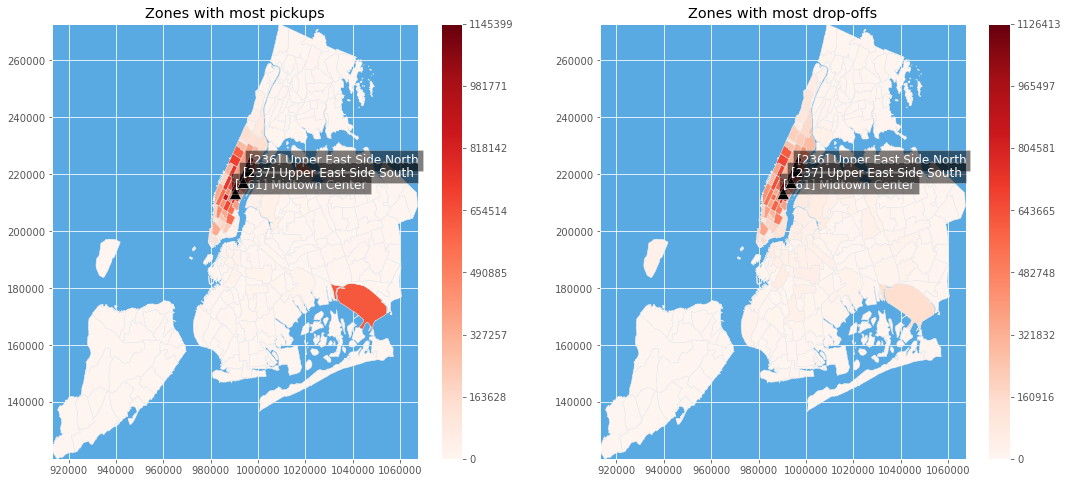

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())
#plt.savefig('../plots/pickupdropoff_2020')

## Compare regional differences in 2019 and 2020

In [32]:
# compare pickup locations 
PU_19

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
237,3641682.0,3256021.0,6897703.0,Upper East Side South,Manhattan
161,3450649.0,3261232.0,6711881.0,Midtown Center,Manhattan
236,3291351.0,3429838.0,6721189.0,Upper East Side North,Manhattan
162,3046788.0,2553027.0,5599815.0,Midtown East,Manhattan
186,3027440.0,2182447.0,5209887.0,Penn Station/Madison Sq West,Manhattan
...,...,...,...,...,...
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan


In [33]:
PU_20

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
237,1145399.0,1015488.0,2160887.0,Upper East Side South,Manhattan
236,1089578.0,1126413.0,2215991.0,Upper East Side North,Manhattan
161,946849.0,843734.0,1790583.0,Midtown Center,Manhattan
186,862318.0,553449.0,1415767.0,Penn Station/Madison Sq West,Manhattan
162,831587.0,666187.0,1497774.0,Midtown East,Manhattan
...,...,...,...,...,...
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan


In [36]:
# merge 
merge = pd.merge(PU_19, PU_20, left_on="LocationID", right_on="LocationID")
merge

,PUcount_x,DOcount_x,TOTALcount_x,zone_x,borough_x,PUcount_y,DOcount_y,TOTALcount_y,zone_y,borough_y
LocationID,,,,,,,,,,
237,3641682.0,3256021.0,6897703.0,Upper East Side South,Manhattan,1145399.0,1015488.0,2160887.0,Upper East Side South,Manhattan
161,3450649.0,3261232.0,6711881.0,Midtown Center,Manhattan,946849.0,843734.0,1790583.0,Midtown Center,Manhattan
236,3291351.0,3429838.0,6721189.0,Upper East Side North,Manhattan,1089578.0,1126413.0,2215991.0,Upper East Side North,Manhattan
162,3046788.0,2553027.0,5599815.0,Midtown East,Manhattan,831587.0,666187.0,1497774.0,Midtown East,Manhattan
186,3027440.0,2182447.0,5209887.0,Penn Station/Madison Sq West,Manhattan,862318.0,553449.0,1415767.0,Penn Station/Madison Sq West,Manhattan
...,...,...,...,...,...,...,...,...,...,...
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan
103,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan,0.0,0.0,0.0,Governor's Island/Ellis Island/Liberty Island,Manhattan


In [39]:
# % Change From Pre-Pandemic Equivalent Day
merge["year_over_year_pickup_rate"] = (merge.PUcount_y - merge.PUcount_x) / merge.PUcount_x
merge["year_over_year_dropoff_rate"] = (merge.DOcount_y - merge.DOcount_x) / merge.DOcount_x

In [41]:
pd.options.display.max_rows = 500

merge

,PUcount_x,DOcount_x,TOTALcount_x,zone_x,borough_x,PUcount_y,DOcount_y,TOTALcount_y,zone_y,borough_y,year_over_year_pickup_rate,year_over_year_dropoff_rate
LocationID,,,,,,,,,,,,
237,3641682.0,3256021.0,6897703.0,Upper East Side South,Manhattan,1145399.0,1015488.0,2160887.0,Upper East Side South,Manhattan,-0.685475,-0.688120
161,3450649.0,3261232.0,6711881.0,Midtown Center,Manhattan,946849.0,843734.0,1790583.0,Midtown Center,Manhattan,-0.725603,-0.741284
236,3291351.0,3429838.0,6721189.0,Upper East Side North,Manhattan,1089578.0,1126413.0,2215991.0,Upper East Side North,Manhattan,-0.668957,-0.671584
162,3046788.0,2553027.0,5599815.0,Midtown East,Manhattan,831587.0,666187.0,1497774.0,Midtown East,Manhattan,-0.727061,-0.739060
186,3027440.0,2182447.0,5209887.0,Penn Station/Madison Sq West,Manhattan,862318.0,553449.0,1415767.0,Penn Station/Madison Sq West,Manhattan,-0.715166,-0.746409
230,2900733.0,2596508.0,5497241.0,Times Sq/Theatre District,Manhattan,687713.0,569064.0,1256777.0,Times Sq/Theatre District,Manhattan,-0.762918,-0.780835
132,2729607.0,783754.0,3513361.0,JFK Airport,Queens,630367.0,146974.0,777341.0,JFK Airport,Queens,-0.769063,-0.812474
48,2678275.0,2340461.0,5018736.0,Clinton East,Manhattan,730145.0,640785.0,1370930.0,Clinton East,Manhattan,-0.727382,-0.726214
170,2604081.0,2643630.0,5247711.0,Murray Hill,Manhattan,754598.0,738633.0,1493231.0,Murray Hill,Manhattan,-0.710225,-0.720599
